In [21]:
import numpy as np

In [22]:
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [23]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [24]:
from keras.models import load_model

In [25]:
pups_cnt_net = load_model("../data/sealion/models/pups/ckpt_cnt_04-3.38.h5")

In [26]:
pups_cnt_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
___________________________________________________________________________________________

In [27]:
class NonValidPatch(Exception):
    pass

In [28]:
def get_block_loc(shape, x, y, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [29]:
class PupsIterator(Iterator):
    """Iterator yielding training samples of pups
    :param root_dir: Directory containing training images, and dots.
    :param image_ids: Set of image ids to use to sample patches.
    :param class_weights: Weights for each class.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(48, 48),
                 batch_size=64, shuffle=True, seed=42, debug_dir=None):
        self.n_samples_per_block = 16
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
            
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PupsIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
    
    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, im):
        flip_hor = np.random.randint(0, 2)
        flip_ver = np.random.randint(0, 2)
        if flip_hor == 1:
            im = cv2.flip(im, 0)
        if flip_ver == 1:
            im = cv2.flip(im, 1)
        return im
    
    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample_position(self, shape, dots, current_weigths):
        # Choose an output class randomly
        output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]
        # Sample a location, either for background or for a sealion.
        if output_class == self.n_sealion_types:
            # avoid bg with pups in it
            return self.sample_bg(shape, dots[4]), output_class
        else:
            return self.sample_dot(shape, dots[output_class]), output_class

    def get_dots_in_block(self, bid, shape, dots, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
        h, w = shape
        w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
        h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
        
        bx = bid % n_blocks[0]
        by = bid // n_blocks[0]
        
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        x_start = bx * (w_block - overlap[1])
        x_end = x_start + w_block + 1
        
        dots_in_block = [[] for _ in range(self.n_sealion_types)]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x_start <= x < x_end and y_start <= y < y_end:
                    dots_in_block[i].append((x - x_start, y - y_start))
        return dots_in_block
        
    def get_random_block(self, image_id, shape, dots, current_weigths):
        while True:
            try:
                (x, y), output_class = self.sample_position(shape, dots, current_weigths)
                
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
                
                # Load the block and check if it is valid
                uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
                img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
                if img is not None:
                    return bid, img
            except NonValidPatch:
                continue
        
    
    def sample(self, shape, dots, image_id):
        # if more than 30% of the patch is masked, reject it
        threshold_masked = 0.3 
        
        # If we are stuck on a "bad" block, we retry from scratch
        while True:
            # Set probability to 0 if some sealion type is not in the block
            current_weigths = self.get_weights(dots)
        
            # Get a block randomly (but using the dots and the sampling weights)
            bid, img = self.get_random_block(image_id, shape, dots, current_weigths)
                
            # Recompute dots in the blocks, and sampling weights
            dots_block = self.get_dots_in_block(bid, shape, dots)
            current_weigths = self.get_weights(dots_block)

            # Now, sample n_samples_per_block patches from it
            n_samples = 0
            bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
            by = np.zeros((self.n_samples_per_block, ))

            # Stop if we try too many times, 
            max_iterations = self.n_samples_per_block * 5
            current_iteration = 0
            while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
                current_iteration += 1
                try:
                    (x, y), output_class = self.sample_position(img.shape[:2], dots_block, current_weigths)
                    img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
                    masked_pixels = np.count_nonzero(img_patch == 0)
                    total_pixels = img_patch.shape[0] * img_patch.shape[1]
                    if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                        continue
                    if masked_pixels/total_pixels < threshold_masked:
                        bx[n_samples, ...] = self.random_transform(img_patch)
                        by[n_samples] = 1 if output_class==4 else 0
                        n_samples += 1
                except NonValidPatch:
                    continue
                    
            if current_iteration < max_iterations:
                return bx, by
            # else, we tried too many times, let's get another block.
        
        
    def contains_dots(self, xstart, ystart, dots, margin):
        x1 = xstart - margin
        y1 = ystart - margin
        x2 = xstart + self.target_size[1] + margin
        y2 = ystart + self.target_size[0] + margin
        for (x, y) in dots:
            if x1 <= x < x2 and y1 <= y < y2:
                return True
        return False
    
    def sample_bg(self, shape, dots):
        margin = 16
        max_iterations = 10
        current_iteration = 0
        while current_iteration < max_iterations:
            x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
            y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
            if not self.contains_dots(x, y, dots, margin):
                return x, y
            current_iteration += 1
        raise NonValidPatch("Cant' find background")
    
    def sample_dot(self, shape, dots):
        margin = self.target_size[0]//8
        
        rand_index = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[rand_index]
        
        min_x = max(0, rand_dot[0] - self.target_size[1]//2 - margin)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] - self.target_size[1]//2 + margin)
        
        min_y = max(0, rand_dot[1] - self.target_size[0]//2 - margin)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] - self.target_size[0]//2 + margin)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block] = y 

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        permut = np.random.permutation(batch_x.shape[0])
        return self.normalize_input(batch_x[permut, ...]), batch_y[permut,...].reshape((-1, 1, 1, 1))

In [30]:
with open("../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [31]:
class_weights = [0.25,  0.25, 0.25, 0.25, 2.0, 0.1]

In [32]:
trainPupsGenerator = PupsIterator("/home/lowik/sealion/data/sealion/", train_ids, class_weights=class_weights)

valPupsGenerator = PupsIterator("/home/lowik/sealion/data/sealion/", val_ids, class_weights=class_weights)

In [33]:
im_val = cv2.imread("/home/lowik/sealion/data/sealion/TrainBlock/43_5.jpg")

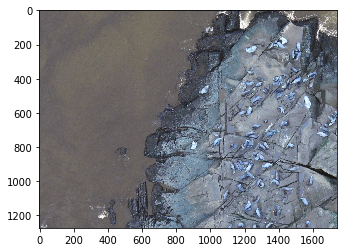

In [34]:
plt.imshow(im_val)

In [35]:
im_val_patch = im_val[:48*22, -1056:, :]

im_val_patch = im_val_patch.reshape((1, 48*22, 1056, 3))

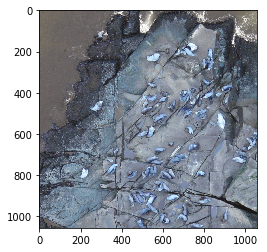

In [36]:
plt.imshow(im_val_patch[0,...])

In [37]:
x = pups_cnt_net.layers[-3].output
pups_net = Model(inputs=[pups_cnt_net.input], outputs=[x])

In [38]:
im_val_pred = pups_net.predict(trainPupsGenerator.normalize_input(im_val_patch.astype(np.float32)))

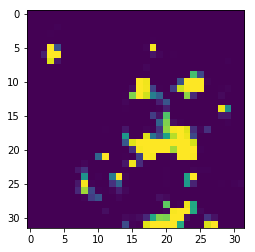

In [39]:
plt.imshow(im_val_pred[0,:,:,0])

In [41]:
384/8

48.0